# Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


# Obtain Data

Read S&P 500 data csv into pandas df

In [2]:
df = pd.read_csv('Data/Prices.csv')
df.head()

,Date,Open,High,Low,Close
0,12/31/19,3215.18,3231.72,3212.03,3230.78
1,12/30/19,3240.09,3240.92,3216.57,3221.29
2,12/27/19,3247.23,3247.93,3234.37,3240.02
3,12/26/19,3227.20,3240.08,3227.20,3239.91
4,12/24/19,3225.45,3226.43,3220.51,3223.38


# Scrub Data

See what data scrubbing needed with df.info

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2724 entries, 0 to 2723
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2724 non-null   object 
 1    Open   2724 non-null   float64
 2    High   2724 non-null   float64
 3    Low    2724 non-null   float64
 4    Close  2724 non-null   float64
dtypes: float64(4), object(1)
memory usage: 106.5+ KB


Drop df columns not useful for modeling

In [4]:
df.drop(columns=[' Open', ' High', ' Low'], inplace=True)
df.head()

,Date,Close
0,12/31/19,3230.78
1,12/30/19,3221.29
2,12/27/19,3240.02
3,12/26/19,3239.91
4,12/24/19,3223.38


Rename Close column to S&P 500 Closing Price

In [5]:
df.rename(columns= {' Close': 'S&P Closing Price'}, inplace=True)
df.head()

,Date,S&P Closing Price
0,12/31/19,3230.78
1,12/30/19,3221.29
2,12/27/19,3240.02
3,12/26/19,3239.91
4,12/24/19,3223.38


Change Date column to datetime data type

In [6]:
df['Date'] = pd.to_datetime(df['Date'], dayfirst=False)
df.head()

,Date,S&P Closing Price
0,2019-12-31,3230.78
1,2019-12-30,3221.29
2,2019-12-27,3240.02
3,2019-12-26,3239.91
4,2019-12-24,3223.38


Order datapoints in ascending order by date

In [7]:
df.sort_values(by='Date', inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()

,Date,S&P Closing Price
0,2009-03-09,676.53
1,2009-03-10,719.60
2,2009-03-11,721.36
3,2009-03-12,750.74
4,2009-03-13,756.55


Confirm dataset now scrubbed with df.info

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2724 entries, 0 to 2723
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               2724 non-null   datetime64[ns]
 1   S&P Closing Price  2724 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 42.7 KB


# Explore Data

Calculate time series descriptive statistics

In [9]:
df['S&P Closing Price'].describe()

count    2724.000000
mean     1887.204710
std       624.475244
min       676.530000
25%      1319.002500
50%      1924.605000
75%      2374.440000
max      3240.020000
Name: S&P Closing Price, dtype: float64

Plot time series dataset

<ipython-input-10-d0c82e76c402>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(date_labels)


Text(0, 0.5, 'Closing Price')

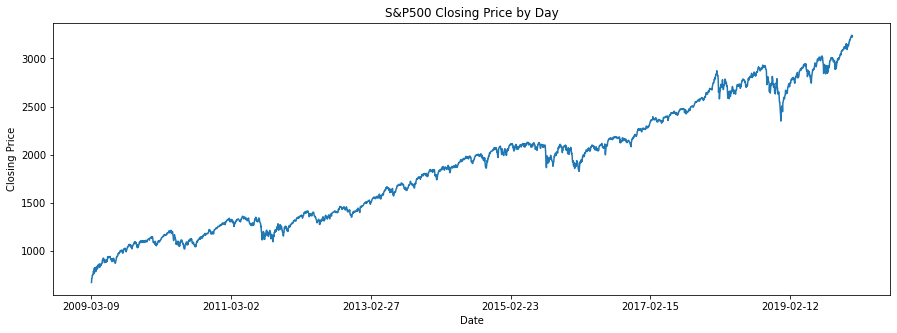

In [10]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(df['S&P Closing Price'].values)
date_labels = [0]
date_labels.extend([str(df.loc[x, 'Date']).split(' ')[0] for x in range(0, 3000, 500)])
ax.set_xticklabels(date_labels)
ax.set_title('S&P500 Closing Price by Day')
ax.set_xlabel('Date')
ax.set_ylabel('Closing Price')

Difference time series data

In [11]:
df['Differenced Price'] = df[['S&P Closing Price']].diff(periods=1)
df.head()

,Date,S&P Closing Price,Differenced Price
0,2009-03-09,676.53,NaN
1,2009-03-10,719.60,43.07
2,2009-03-11,721.36,1.76
3,2009-03-12,750.74,29.38
4,2009-03-13,756.55,5.81


Calculate differenced time series descriptive statistics

In [12]:
df['Differenced Price'].describe()

count    2723.000000
mean        0.938028
std        17.082972
min      -113.190000
25%        -6.100000
50%         1.210000
75%         9.340000
max       116.600000
Name: Differenced Price, dtype: float64

Plot differenced time series data

<ipython-input-13-cb91582f368d>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(date_labels)


Text(0, 0.5, 'Closing Price')

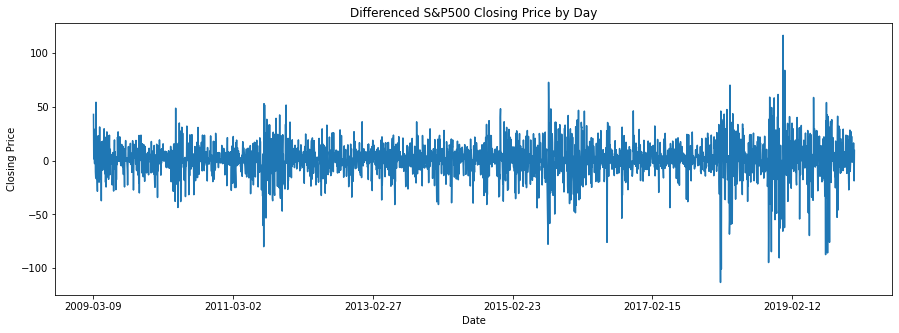

In [13]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(df['Differenced Price'].values)
date_labels = [0]
date_labels.extend([str(df.loc[x, 'Date']).split(' ')[0] for x in range(0, 3000, 500)])
ax.set_xticklabels(date_labels)
ax.set_title('Differenced S&P500 Closing Price by Day')
ax.set_xlabel('Date')
ax.set_ylabel('Closing Price')

Run Dickey-Fuller test on differenced time series data

In [14]:
adfuller(df['Differenced Price'][1:])

(-12.998412457721754,
 2.7193325008130615e-24,
 18,
 2704,
 {'1%': -3.43277067999415,
  '5%': -2.862609479032774,
  '10%': -2.567339319094438},
 22911.05603338416)

Plot time series acf

Text(0, 0.5, 'Correlation')

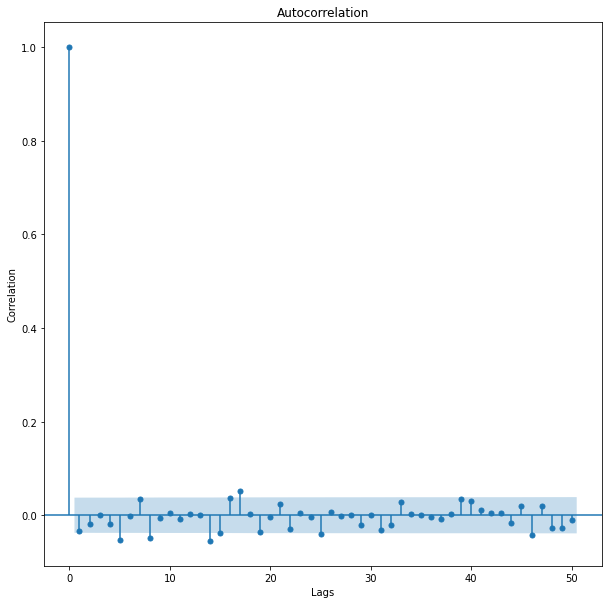

In [15]:
fig, ax = plt.subplots(figsize=(10,10))
plot_acf(df['Differenced Price'][1:], alpha=.05, lags = 50, ax=ax)
ax.set_xlabel('Lags')
ax.set_ylabel('Correlation')

Plot time series pacf

Text(0, 0.5, 'Correlation')

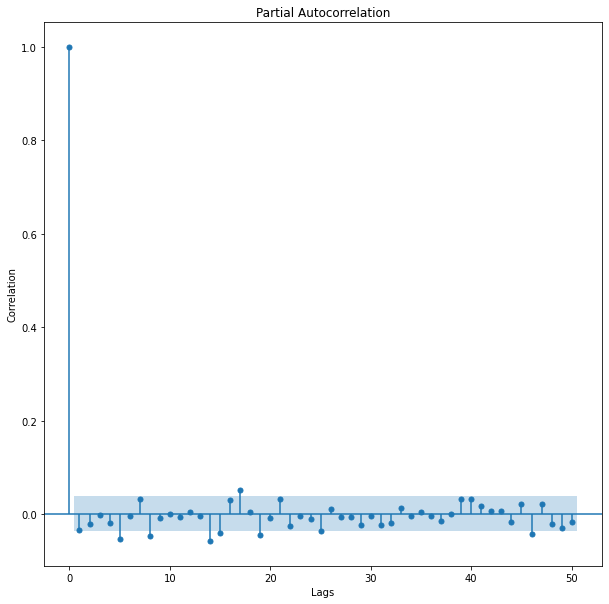

In [16]:
fig, ax = plt.subplots(figsize=(10,10))
plot_pacf(df['Differenced Price'][1:], alpha=.05, lags = 50, ax=ax)
ax.set_xlabel('Lags')
ax.set_ylabel('Correlation')

# ARIMA Model

Perform train test split

In [17]:
test_size = round(len(df['Differenced Price'].values[1:])*.2)
train_series = df['Differenced Price'].values[1 : -test_size]
val_series = df['Differenced Price'].values[-test_size : ]

Build and validate persistance model

In [18]:
train_predictions = train_series[0:-1]
train_actuals = train_series[1:]
val_predictions = val_series[0:-1]
val_actuals = val_series[1:]
print('Train RMSE:', np.sqrt(mean_squared_error(train_actuals, train_predictions)))
print('Train MAE:', mean_absolute_error(train_actuals, train_predictions))
print('Validation RMSE:', np.sqrt(mean_squared_error(val_actuals, val_predictions)))
print('Validation MAE:', mean_absolute_error(val_actuals, val_predictions))

Train RMSE: 20.903491007209073
Train MAE: 15.499839228295825
Validation RMSE: 35.60133815850847
Validation MAE: 24.95547794117647


Build and validate mean based dummy model

In [19]:
train_mean_predictions = [train_series.mean()]*len(train_series)
train_mean_actuals = train_series
val_mean_predictions = [train_series.mean()]*len(val_series)
val_mean_actuals = val_series
print('Train RMSE:', np.sqrt(mean_squared_error(train_mean_actuals, train_mean_predictions)))
print('Train MAE:', mean_absolute_error(train_mean_actuals, train_mean_predictions))
print('Validation RMSE:', np.sqrt(mean_squared_error(val_mean_actuals, val_mean_predictions)))
print('Validation MAE:', mean_absolute_error(val_mean_actuals, val_mean_predictions))

Train RMSE: 14.491666349805767
Train MAE: 10.338917727234785
Validation RMSE: 24.865500125838956
Validation MAE: 17.292760027295483


Fit ARIMA model to time series data

In [20]:
arima = ARIMA(train_series, order = (1, 0, 10))
arima_model = arima.fit()
print(arima_model.summary())
print(arima_model.params)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2178
Model:                ARIMA(1, 0, 10)   Log Likelihood               -8903.483
Date:                Wed, 11 May 2022   AIC                          17832.966
Time:                        15:26:56   BIC                          17906.886
Sample:                             0   HQIC                         17859.991
                               - 2178                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8648      0.279      3.102      0.002       0.318       1.411
ar.L1          0.0602      1.933      0.031      0.975      -3.729       3.849
ma.L1         -0.1050      1.934     -0.054      0.9

Calculate evaluation metrics for arima model

In [21]:
val_pred_arima = arima_model.forecast(steps=len(val_series))
print('Validation RMSE:', np.sqrt(mean_squared_error(val_series, val_pred_arima)))
print('Validation MAE:', mean_absolute_error(val_series, val_pred_arima))

Validation RMSE: 24.86547660231165
Validation MAE: 17.294337287157024


Plot arima predictions vs. actuals

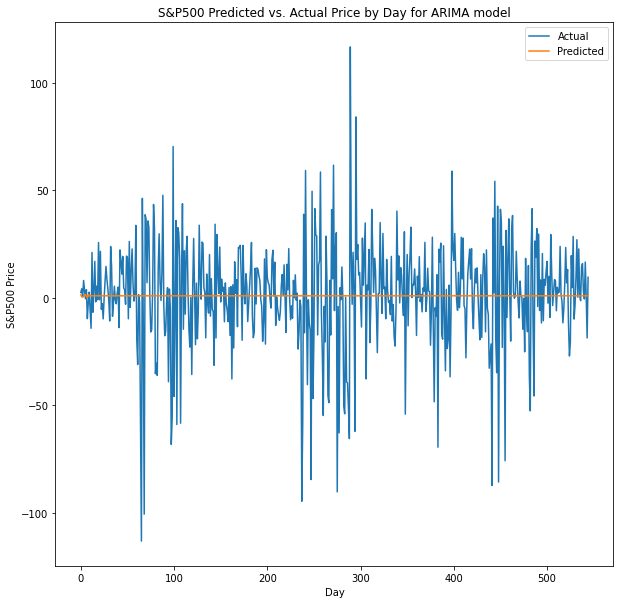

In [22]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(range(0, len(val_series)),val_series)
ax.plot(range(0,len(val_pred_arima)),val_pred_arima)
ax.set_xlabel('Day')
ax.set_ylabel('S&P500 Price')
ax.set_title('S&P500 Predicted vs. Actual Price by Day for ARIMA model')
ax.legend(labels = ['Actual','Predicted'])

# Facebook Prophet Model

Build facebook prophet model

In [23]:
fb_df = df.iloc[1:-len(val_series), [0, 1]]
fb_df.columns = ['ds','y']
prophet = Prophet()
prophet.fit(fb_df)
prophet_dates_df = prophet.make_future_dataframe(periods=len(val_series), freq='D')
prophet_preds_df = prophet.predict(df=prophet_dates_df)
prophet_preds_df.head()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2009-03-10,754.822108,734.433118,825.401892,754.822108,754.822108,24.031276,24.031276,24.031276,7.496074,7.496074,7.496074,16.535202,16.535202,16.535202,0.0,0.0,0.0,778.853384
1,2009-03-11,756.381886,736.970072,828.886312,756.381886,756.381886,24.601383,24.601383,24.601383,7.586338,7.586338,7.586338,17.015045,17.015045,17.015045,0.0,0.0,0.0,780.983269
2,2009-03-12,757.941665,736.437304,825.764147,757.941665,757.941665,25.731087,25.731087,25.731087,8.204815,8.204815,8.204815,17.526272,17.526272,17.526272,0.0,0.0,0.0,783.672752
3,2009-03-13,759.501443,741.796631,831.419552,759.501443,759.501443,25.903050,25.903050,25.903050,7.840120,7.840120,7.840120,18.062930,18.062930,18.062930,0.0,0.0,0.0,785.404493
4,2009-03-16,764.180779,749.065154,832.928116,764.180779,764.180779,26.928437,26.928437,26.928437,7.184732,7.184732,7.184732,19.743705,19.743705,19.743705,0.0,0.0,0.0,791.109217


Plot facebook prophet time series components

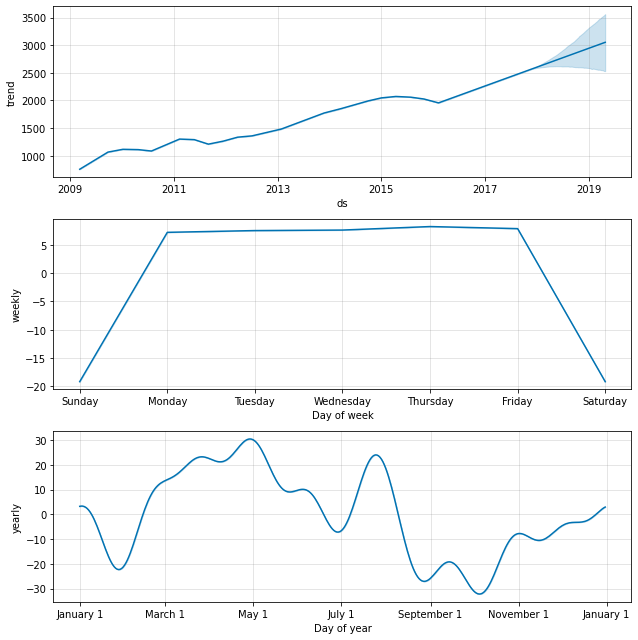

In [24]:
prophet.plot_components(prophet_preds_df);

Plot facebook prophet time series predictions

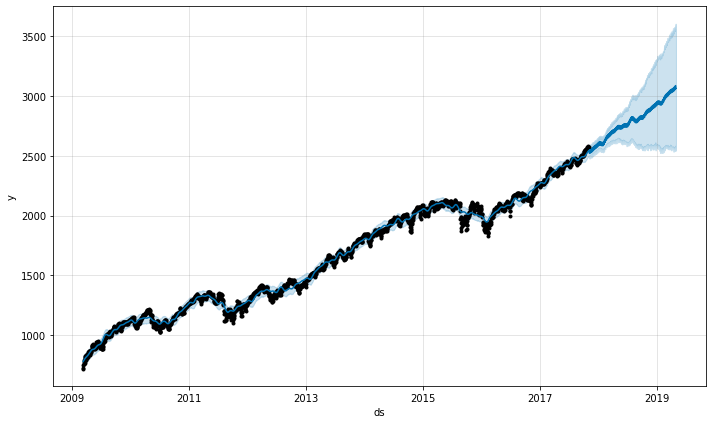

In [25]:
prophet.plot(prophet_preds_df);

Perform train test split on undifferenced data

In [26]:
train_series_prophet = df['S&P Closing Price'].values[1 : -test_size]
val_series_prophet = df['S&P Closing Price'].values[-test_size : ]

Build and validate persistance based dummy model for undifferenced data

In [27]:
train_predictions_prophet = train_series_prophet[0:-1]
train_actuals_prophet = train_series_prophet[1:]
val_predictions_prophet = val_series_prophet[0:-1]
val_actuals_prophet = val_series_prophet[1:]
print('Train RMSE:', np.sqrt(mean_squared_error(train_actuals_prophet, train_predictions_prophet)))
print('Train MAE:', mean_absolute_error(train_actuals_prophet, train_predictions_prophet))
print('Validation RMSE:', np.sqrt(mean_squared_error(val_actuals_prophet, val_predictions_prophet)))
print('Validation MAE:', mean_absolute_error(val_actuals_prophet, val_predictions_prophet))

Train RMSE: 14.491761730774925
Train MAE: 10.370900321543411
Validation RMSE: 24.915164809810115
Validation MAE: 17.39691176470589


Calculate evaluation metrics for facebook prophet model

In [28]:
val_pred_prophet = prophet_preds_df.iloc[-test_size:, -1].values
print('Validation RMSE:', np.sqrt(mean_squared_error(val_series_prophet, val_pred_prophet)))
print('Validation MAE:', mean_absolute_error(val_series_prophet, val_pred_prophet))

Validation RMSE: 105.69542055031627
Validation MAE: 81.18011397762125


Plot facebook prophet predictions vs. actuals

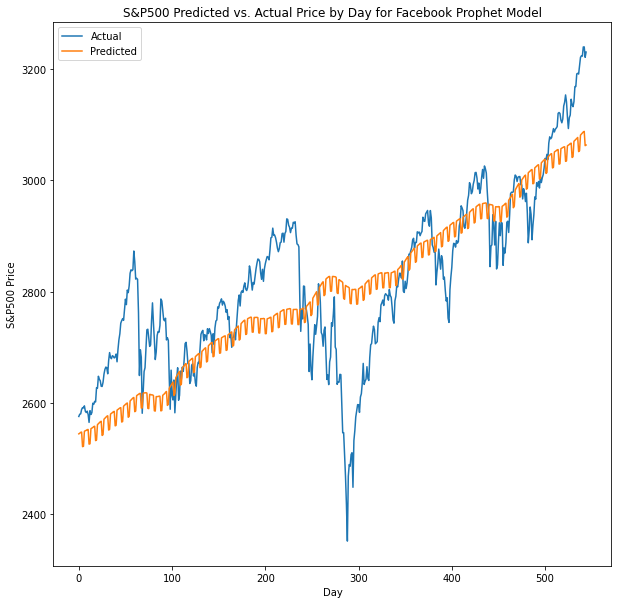

In [29]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(range(0, len(val_series_prophet)),val_series_prophet)
ax.plot(range(0,len(val_pred_prophet)),val_pred_prophet)
ax.set_xlabel('Day')
ax.set_ylabel('S&P500 Price')
ax.set_title('S&P500 Predicted vs. Actual Price by Day for Facebook Prophet Model')
ax.legend(labels = ['Actual','Predicted'])